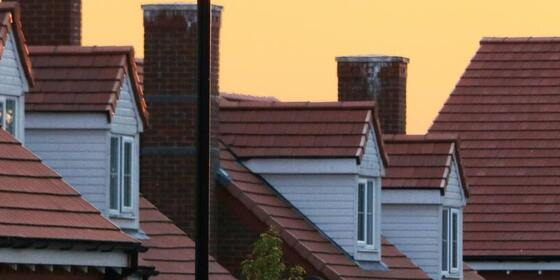

#**Kaggle-HousePrices-Study**

## **데이터 및 라이브러리 불러오기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

base_path = os.path.join(os.getcwd(), 'drive','MyDrive' ,'datasets', 'house-prices')
train = pd.read_csv(os.path.join(base_path, 'train.csv')) #Train data Load
test = pd.read_csv(os.path.join(base_path, 'test.csv')) #Test data Load
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

## 자주쓰는 함수 모아두기

In [3]:
def viz_skatters(columns, target):
  num_of_columns = len(columns)

  fig, ax = plt.subplots(nrows=num_of_columns, ncols=1, figsize=(6, 4 * num_of_columns))

  for i in range(num_of_columns):
    # 그래프 그리기
    ax[i].scatter(train[columns[i]], train[target])  # 산점도 찍기
    m, b = np.polyfit(train[columns[i]], train[target], 1)  # 기울기(m)와 절편(b) 계산
    ax[i].plot(train[columns[i]], m*train[columns[i]] + b, color='red')  # 회귀선 그리기

    # 그 외것 설정하기
    ax[i].set_title(f'{columns[i]} vs {target}')  # 타이틀 설정

  plt.show()


def viz_skatter(column, target):

  fig, ax = plt.subplots(figsize=(6, 4))

  ax.scatter(column, target)  # 산점도 찍기
  m, b = np.polyfit(column, target, 1)  # 기울기(m)와 절편(b) 계산
  ax.plot(column, m*column + b, color='red')  # 회귀선 그리기

  plt.show()

## **데이터 기본 정보 확인하기**

In [4]:
# print(df.shape)  # 데이터의 크기 확인
# print(df.dtypes)  # 각 열의 데이터 타입 확인
# print(df.describe())  # 기본 통계량 확인

train.shape

(1460, 81)

In [5]:
train.dtypes

,0
Id,int64
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
...,...
MoSold,int64
YrSold,int64
SaleType,object
SaleCondition,object


In [6]:
train.dtypes.value_counts()

,count
object,43
int64,35
float64,3


## **결측치 확인**

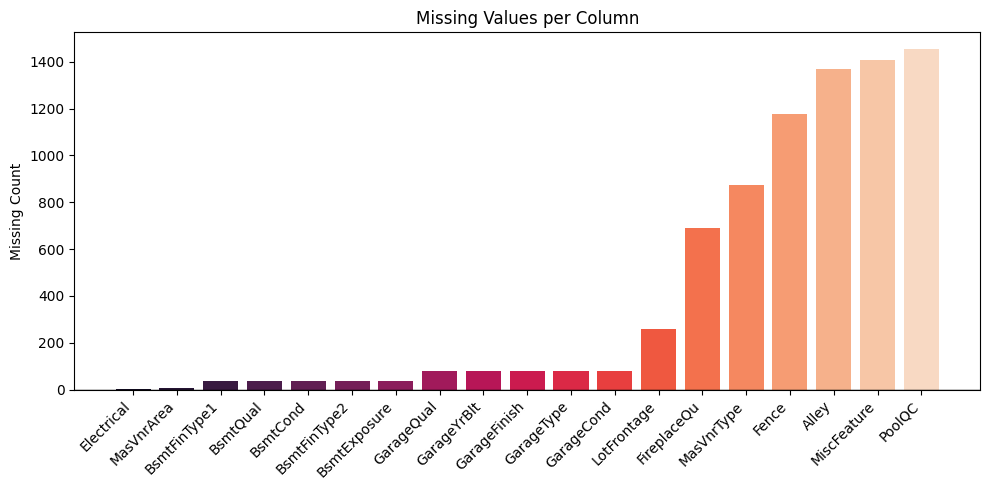

In [7]:
missing_value = train.isnull().sum().sort_values()
missing_value = missing_value[missing_value > 0]

colors = sns.color_palette("rocket", n_colors=len(missing_value))

plt.figure(figsize=(10, 5))
bars = plt.bar(missing_value.index, missing_value.values, color=colors)
plt.bar(missing_value.index, missing_value.values, color=colors)  # 색상은 자유롭게 선택
plt.axhline(0, color='k', linewidth=1)  # y=0 기준선

plt.xticks(rotation=45, ha='right')  # X축 라벨 회전
plt.ylabel("Missing Count")
plt.title("Missing Values per Column")

plt.tight_layout()
plt.show()

### **결측치 타입 확인**

In [8]:
train.loc[:, train.isnull().any()].dtypes

,0
LotFrontage,float64
Alley,object
MasVnrType,object
MasVnrArea,float64
BsmtQual,object
BsmtCond,object
BsmtExposure,object
BsmtFinType1,object
BsmtFinType2,object
Electrical,object


### **결측치 처리**

#### **1. 실제로 없어서 없는 값들 처리**

MNAR 유형이고, 실제로 없는 값이라 타겟에 영향이 가기 때문에, 실제로 없는 'None'으로 채워넣어줌

In [9]:
train['PoolQC'] = train['PoolQC'].fillna(value= 'None')  # 실제로 수영장이 없음
train['MiscFeature'] = train['MiscFeature'].fillna('None')  # 실제로 특이사항이 없음
train['Alley'] = train['Alley'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
train['GarageCond'] = train['GarageCond'].fillna('None')  # 주차장이 실제로 존재하지 않음.
train['GarageType'] = train['GarageType'].fillna('None')
train['GarageFinish'] = train['GarageFinish'].fillna('None')
train['GarageYrBlt'] = train['GarageYrBlt'].fillna('None')
train['GarageQual'] = train['GarageQual'].fillna('None')

#### **실제로 존재하거나, 애매한 것**

* 타겟과 연관이 있는지 판단 후, 판단이 없다면 Drop 예정

1. LotFrontage
2. MasVnrType
3. MasVnrArea
4. BsmtQual
5. BsmtCond
6. BsmtFinType1
7. BsmtFinType2
8. Electrical

4~7번 항목은 같은 분류로 들어가서 같이 분석할 예정이다.

##### **1. LotFrontage (도로와 접한 선형 거리)**

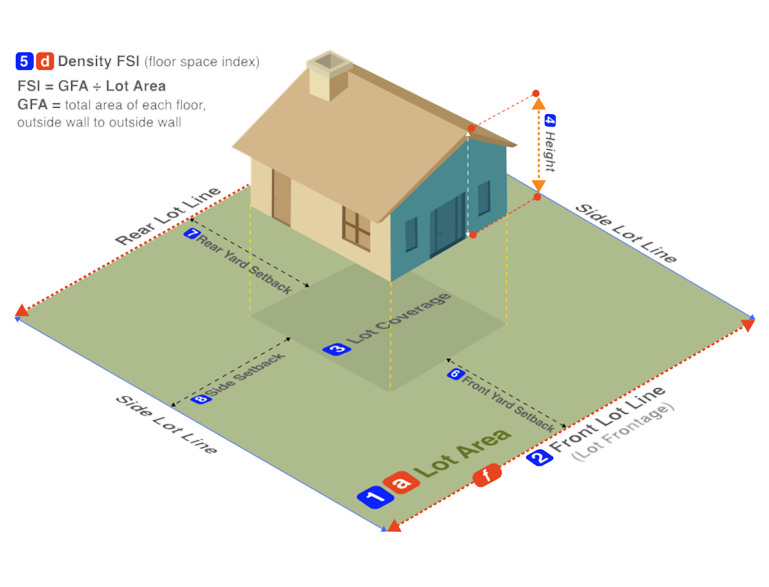

토지면적 중 정면의 길이를 LotFrontage라고 한다.

1. 결측치 비율 파악

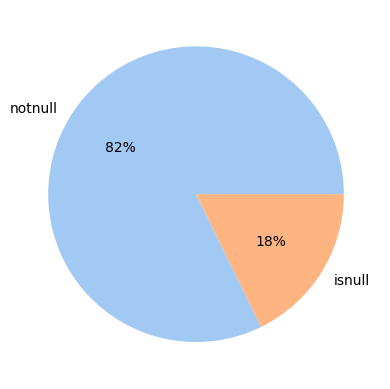

In [10]:
data = [train.LotFrontage.notnull().sum(), train.LotFrontage.isnull().sum()]
labels = ['notnull', 'isnull']

colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

결측치가 무려 18%나 되는 걸 보니 생각보다 많으므로 다른 컬럼과 그룹핑해, 결측치를 처리하겠음

2. Neighborhood (거주지역) 즉, 이웃집과 유사하다는 가정 하에 결측치를 채우겠습니다.

In [11]:
train["LotFrontage"] = train.groupby(["Neighborhood", "OverallQual"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))
train["LotFrontage"] = train.groupby(["Neighborhood"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))

##### **2. MasVnrType / MasVnrArea(석조 벽재 마감재 및 면적)**

In [12]:
train[['MasVnrType', 'MasVnrArea']].head(3)

,MasVnrType,MasVnrArea
0,BrkFace,196.0
1,NaN,0.0
2,BrkFace,162.0


In [13]:
train.MasVnrArea.isnull().sum()

np.int64(8)

In [14]:
train.MasVnrType.isnull().sum()

np.int64(872)

둘의 수의 차이가 너무 커서, 우선 둘 다 결측치인 경우를 먼져 찾아봄

In [15]:
train[(train.MasVnrArea.isnull()) & (train.MasVnrType.isnull())]  # 총 8개이다 실제로 존재하지 않는거다.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,65.0,7851,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2010,WD,Normal,216500
529,530,20,RL,79.5,32668,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,None,None,None,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,3,2008,WD,Normal,237000


In [16]:
train['MasVnrArea'] = train['MasVnrArea'].fillna('None')  #바로 None으로 채워넣어버림

In [17]:
train[['MasVnrType', 'Exterior1st', 'Exterior2nd', 'Neighborhood', 'HouseStyle']].head(30)

,MasVnrType,Exterior1st,Exterior2nd,Neighborhood,HouseStyle
0,BrkFace,VinylSd,VinylSd,CollgCr,2Story
1,NaN,MetalSd,MetalSd,Veenker,1Story
2,BrkFace,VinylSd,VinylSd,CollgCr,2Story
3,NaN,Wd Sdng,Wd Shng,Crawfor,2Story
4,BrkFace,VinylSd,VinylSd,NoRidge,2Story
5,NaN,VinylSd,VinylSd,Mitchel,1.5Fin
6,Stone,VinylSd,VinylSd,Somerst,1Story
7,Stone,HdBoard,HdBoard,NWAmes,2Story
8,NaN,BrkFace,Wd Shng,OldTown,1.5Fin
9,NaN,MetalSd,MetalSd,BrkSide,1.5Unf


In [18]:
train[(train.Exterior1st == 'BrkComm')]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
410,411,20,RL,68.0,9571,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,6,2009,COD,Abnorml,60000
1000,1001,20,RL,74.0,10206,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,7,2009,WD,Normal,82000


In [19]:
def fill_var_type(value):
  if pd.isna(value['MasVnrType']):
    if value['Exterior1st'] == 'Stone':
      fill = 'Stone'
    else:
      try:
        fill = train[(train['Exterior1st'] == value['Exterior1st']) & (train['Exterior2nd'] == value['Exterior2nd']) & (train['Neighborhood'] == value['Neighborhood'])]['MasVnrType'].mode().iloc[0]
      except:
        try:
          fill = train[(train['Exterior1st'] == value['Exterior1st']) & (train['Exterior2nd'] == value['Exterior2nd'])]['MasVnrType'].mode().iloc[0]
        except:
          try:
            fill = train[(train.Neighborhood == value['Neighborhood'])]['MasVnrType'].mode().iloc[0]
          except:
              fill = train[(train['Exterior1st'] == value['Exterior1st'])]['MasVnrType'].mode().iloc[0]
  else:
      fill = value['MasVnrType']
  return fill

train['MasVnrType'] = train.apply(fill_var_type, axis=1)

##### **3. BsmtFinType1 / BsmtQual / BsmtCond / BsmtFinType2 / BsmtExposure**

In [20]:
print(train.BsmtFinType1.isnull().sum())
print(train.BsmtFinType2.isnull().sum())
print(train.BsmtQual.isnull().sum())
print(train.BsmtCond.isnull().sum())
print(train.BsmtExposure.isnull().sum())

#38개짜리가 뭐지?

37
38
37
37
38


In [21]:
mv = train[(train.BsmtFinType1.notnull()) & (train.BsmtFinType2.isnull())]
mv[['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']]

mv = train.loc[332]
missing_value_mode = train[(train.BsmtFinType1 == mv.BsmtFinType1) & (train.BsmtQual == mv.BsmtQual) & (train.BsmtCond == mv.BsmtCond)]['BsmtFinType2'].mode().iloc[0]

print(f'fill missing value: {missing_value_mode}')
train.loc[332, 'BsmtFinType2'] = missing_value_mode

fill missing value: Unf


In [22]:
print(train.BsmtFinType1.isnull().sum())
print(train.BsmtFinType2.isnull().sum())
print(train.BsmtQual.isnull().sum())
print(train.BsmtCond.isnull().sum())
print(train.BsmtExposure.isnull().sum())

#개수 맞추기 완료 인줄 알았다.

37
37
37
37
38


In [23]:
mv = train[(train.BsmtFinType1.notnull()) & (train.BsmtExposure.isnull())]
mv[['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']]
mv = train.loc[948]

missing_value_mode = train[(train.BsmtFinType1 == mv.BsmtFinType1) & (train.BsmtQual == mv.BsmtQual) & (train.BsmtCond == mv.BsmtCond)]['BsmtExposure'].mode().iloc[0]
print(f'fill missing value: {missing_value_mode}')
train.loc[948, 'BsmtExposure'] = missing_value_mode

fill missing value: No


In [24]:
print(train.BsmtFinType1.isnull().sum())
print(train.BsmtFinType2.isnull().sum())
print(train.BsmtQual.isnull().sum())
print(train.BsmtCond.isnull().sum())
print(train.BsmtExposure.isnull().sum())

37
37
37
37
37


In [25]:
bsmt = train[(train.BsmtFinType1.isnull()) & (train.BsmtFinType2.isnull()) & (train.BsmtQual.isnull()) & (train.BsmtCond.isnull()) & (train.BsmtExposure.isnull())]
bsmt[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

#실제로 지하실이 없던거였음.

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0


In [26]:
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('None')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('None')
train['BsmtQual'] = train['BsmtQual'].fillna('None')
train['BsmtCond'] = train['BsmtCond'].fillna('None')
train['BsmtExposure'] = train['BsmtExposure'].fillna('None')

## **이상치 탐지 및 해당 열 삭제**



---



TargetData (SalePrice)의 분포도를 보면 주로 100000 - 200000에 가장 많이 분포함을 알 수 있다.

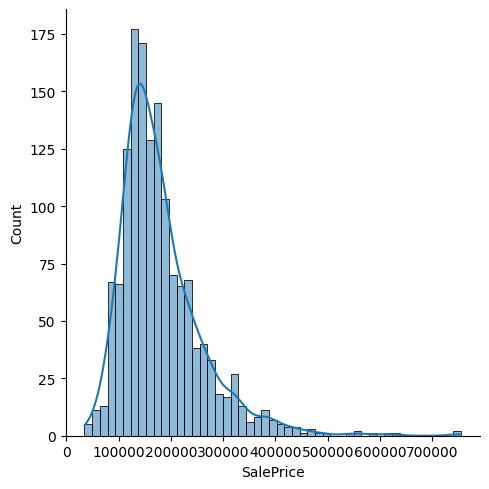

In [27]:
sns.displot(train['SalePrice'], kde=True)

### TargetData 상관계수 상위 10개 확인하기

81개 컬럼을 모두 보면 좋겠으나, 여건이 안되므로 상위 10개만 살펴보자

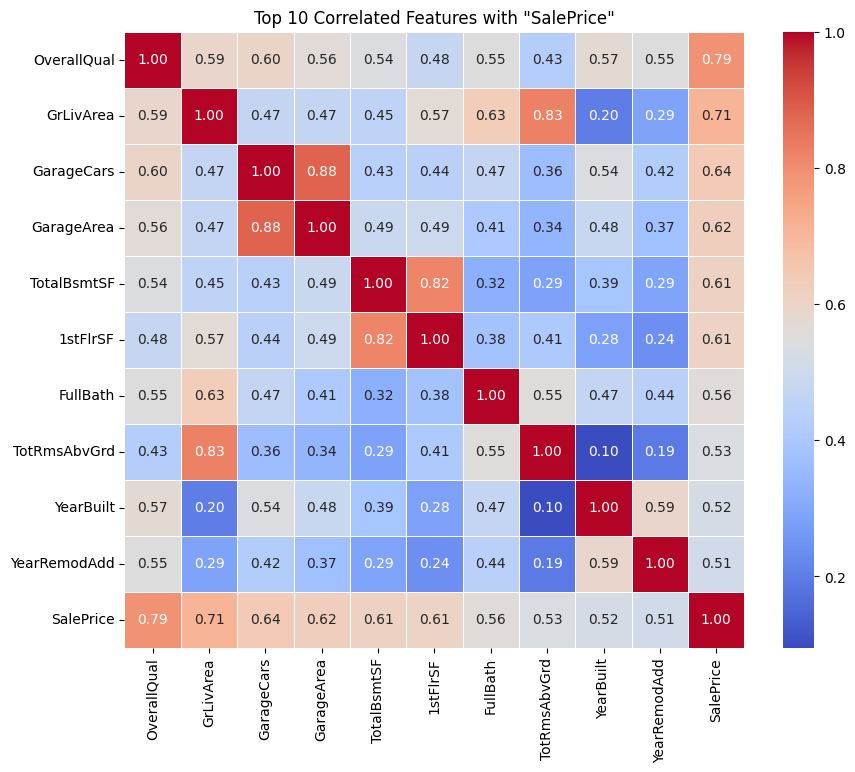

In [28]:
# 수치형만 선택
numeric_data = train.select_dtypes(include=['int64', 'float64'])

# 상관관계 행렬 계산
corr_matrix = numeric_data.corr()

# 특정 컬럼 선택
target_column = 'SalePrice'  # ← 여기에 원하는 열 이름 입력

# 해당 컬럼과 상관관계가 높은 상위 10개 변수 (자기 자신 제외)
top_10 = corr_matrix[target_column].drop(labels=[target_column])  # 자기 자신 제외
top_10 = top_10.abs().sort_values(ascending=False).head(10).index.tolist()

# 시각화용 상관관계 매트릭스 추출 (target 포함해서 함께 보기)
cols_to_plot = top_10 + [target_column]
filtered_corr = corr_matrix.loc[cols_to_plot, cols_to_plot]

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Top 10 Correlated Features with "{target_column}"')
plt.show()

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

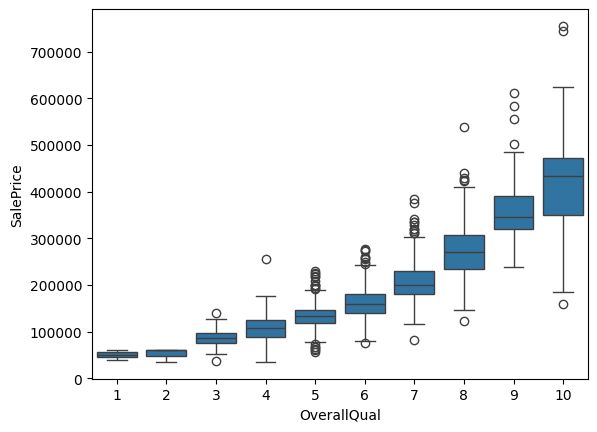

In [29]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train)  #4, 8, 10 에서 이상치 발견

In [30]:
col = 'OverallQual'

Q1 = train[col].quantile(0.25)
Q3 = train[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

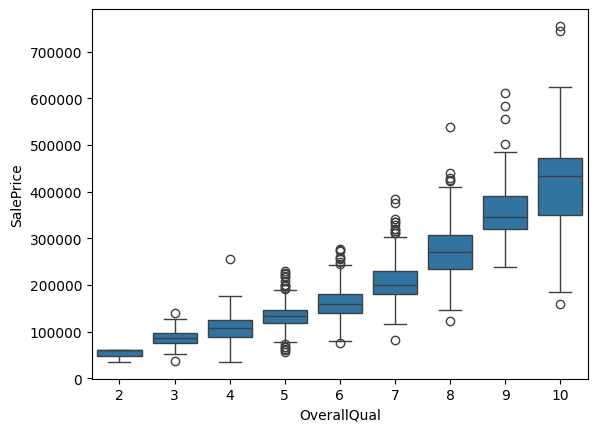

In [31]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train)  #4, 8, 10 에서 이상치 발견

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

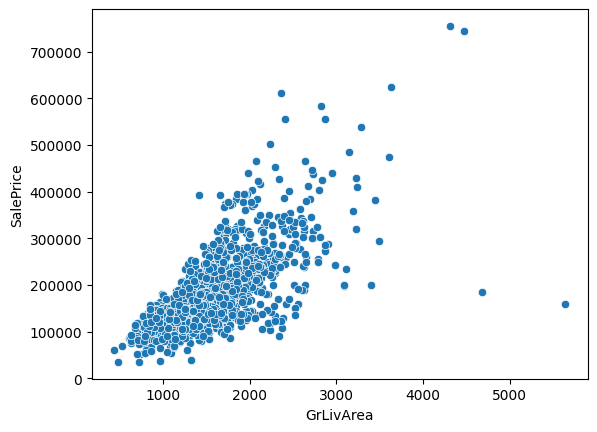

In [32]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)  # 4000 이상은 자르는게 좋아보인다. (분포도 확인)

In [33]:
train = train[(train.GrLivArea < 4000)]

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

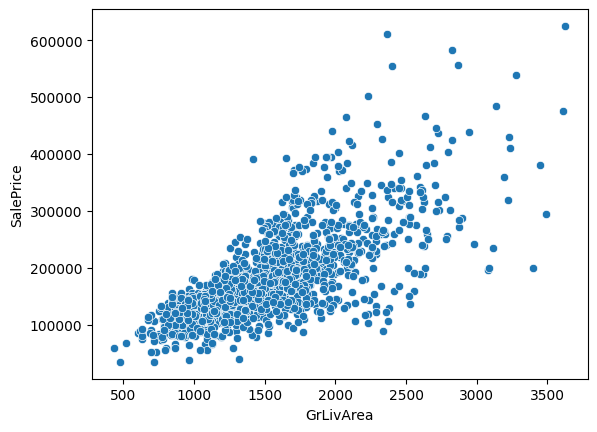

In [34]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)  #제거 완료! (골고루 분포함을 확인함.)

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

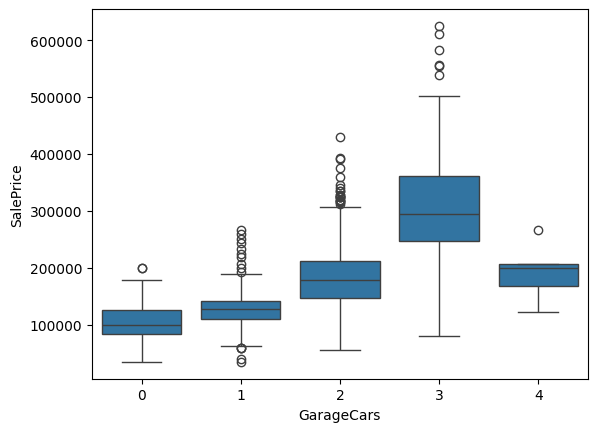

In [35]:
sns.boxplot(x='GarageCars', y='SalePrice', data=train)  # 4대 항목을 보면 좀 이상하다.

In [36]:
col = 'GarageCars'

Q1 = train[col].quantile(0.25)
Q3 = train[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

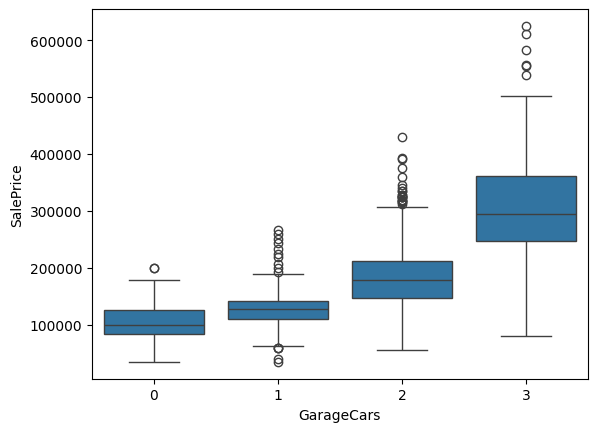

In [37]:
sns.boxplot(x='GarageCars', y='SalePrice', data=train)  # IQR 기법으로 제거 완료

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

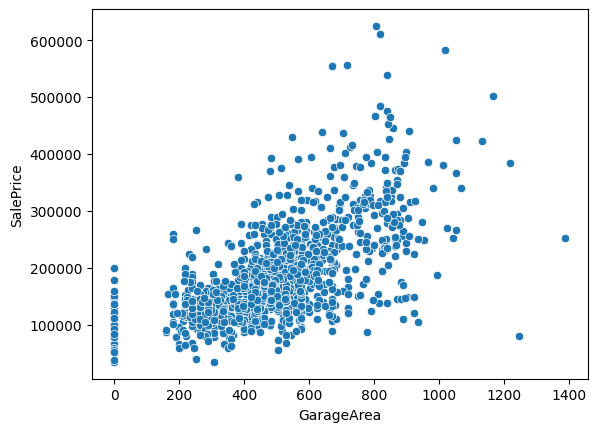

In [ ]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

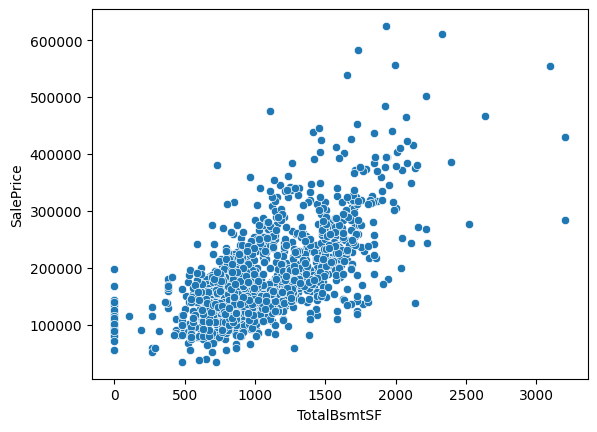

In [40]:
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train)

<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

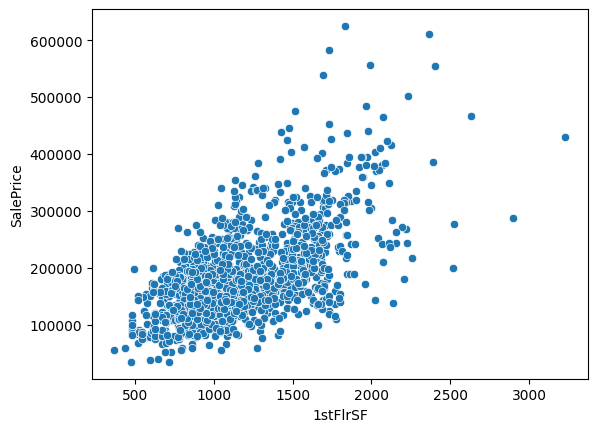

In [41]:
sns.scatterplot(x='1stFlrSF', y='SalePrice', data=train)

<Axes: xlabel='FullBath', ylabel='SalePrice'>

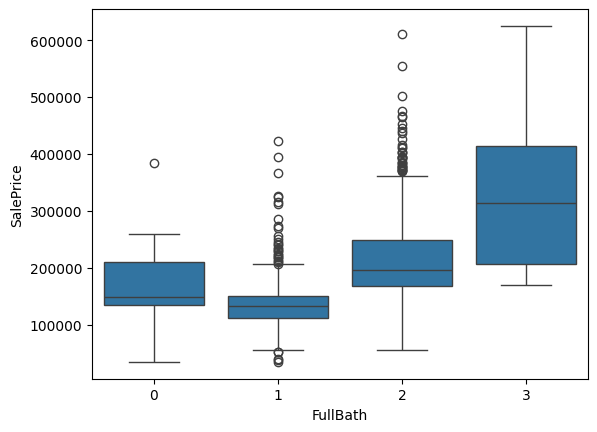

In [43]:
sns.boxplot(x='FullBath', y='SalePrice', data=train)

In [45]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
